------------------------------------------------------------------------------------------------------------------------------------------------------

## CALIBRATION NOTEBOOK


##### PLEASE! When you are done with the tutorial, move to the ```notebooks``` folder to start your own analysis 
 In this way, you will be able to keep the tutorial as a reference for future use (or others to use it).

------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import sys; sys.path.insert(0, '../'); from lib import *;
figure_features()

Welcome to JupyROOT 6.28/00
You have latex installed!. Applying default configuration (tex=True)


In [12]:
# Set options for general visualitation
OPT  = {
    "MICRO_SEC":   True,                # Time in microseconds (True/False)
    "NORM":        False,               # Runs can be displayed normalised (True/False)
    "ALIGN":       True,                # Aligns waveforms in peaktime (True/False)
    "LOGY":        False,               # Runs can be displayed in logy (True/False)
    "SHOW_AVE":    "",                  # If computed, vis will show average (AveWvf,AveWvfSPE,etc.)
    "SHOW_PARAM":  False,               # Print terminal information (True/False)
    "CHARGE_KEY":  "ChargeAveRange",    # Select charge info to be displayed. Default: "ChargeAveRange" (if computed)
    "PEAK_FINDER": False,               # Finds possible peaks in the window (True/False)
    "LEGEND":      True,                # Shows plot legend (True/False)
    "SHOW":        True,
    "THRESHOLD":  1,
    "WIDTH":      15,
    "PROMINENCE": 0.4,
    "ACCURACY":   1000
    }

In [14]:
info           = read_input_file("TUTORIAL") # Read input file
calib_runs     = [ 1]                        # Calibration runs
laser_runs     = [ 9]                        # Laser runs
alpha_runs     = [25]                        # Alpha runs
muons_runs     = [29]                        # Muons runs
noise_runs     = [128]                       # Noise runs

channels = [0,6]

In [15]:
my_runs_calib = load_npy(np.asarray(calib_runs).astype(int),np.asarray(channels).astype(int),preset="EVA",info=info,compressed=True)

load_npy --> DONE!

load_npy --> DONE!



## BEFORE DECONVOLUTION


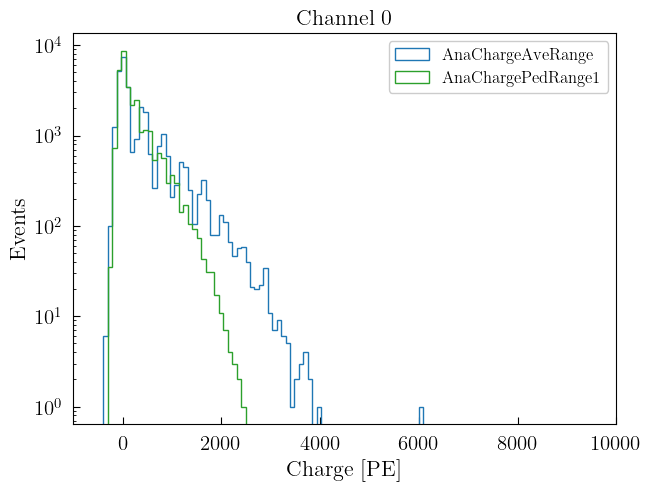

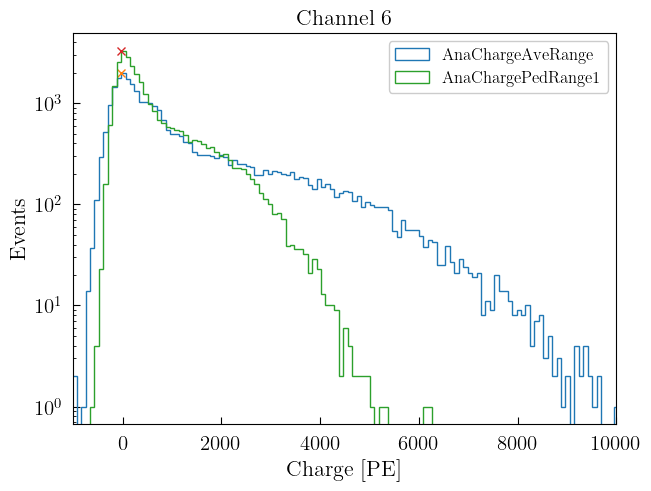

In [31]:
keys = ["AnaChargeAveRange","AnaChargePedRange1"]; debug = True

for c,ch in enumerate(channels):
    for key in keys: 
        plt.hist(my_runs_calib[calib_runs[0]][ch][key], 500,np.array([-0.1,1.4])*3e4,histtype="step", label=key);
        counts,bins= np.histogram(my_runs_calib[calib_runs[0]][ch][key],500,np.array([-0.1,1.4])*3e4);
        peaks=find_peaks(counts,height=200,width=4)
        plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x")

    plt.semilogy()
    plt.xlim([-1e3,1e4])
    plt.xlabel("Charge [PE]")
    plt.ylabel("Events")
    plt.title("Channel %i"%ch)
    plt.legend()
    plt.show()

## AFTER DECONVOLUTION

In [ ]:
for c, ch in enumerate(channels):
    fast =np.sum(my_runs_calib[calib_runs[0]][ch]["DecADC"][:,500:1000],axis=1)
    total=np.sum(my_runs_calib[calib_runs[0]][ch]["DecADC"][:,500:3000],axis=1)

    plt.plot(total,fast/total,',')
    plt.ylim([0,1])
    plt.xlim([0,1000])
    CUT=(fast>0.7)*(total>130)
    plt.hist(total[CUT],200,[100,1000]);
    plt.semilogy()
    plt.grid()
    plt.show()

In [ ]:
# With cuts
f90 = fast/total
CUT_total = total>100
CUT_tf90  = f90>0.6
CUT = CUT_tf90*CUT_total

plt.figure(dpi=200)
Amp=np.max(my_runs_calib[calib_runs[0]][ch]["DecADC"],axis=1)
plt.plot(total[~CUT], Amp[~CUT], ",");
plt.plot(total[CUT] , Amp[CUT] , ",");
plt.xlim([0,1000])
plt.ylabel("Amp [Arb units]")
plt.xlabel("Charge [Arb units]")
x_ticks=np.arange(0,1000,1)
plt.plot(x_ticks,0.01*x_ticks)
plt.show()

## GAIN FIT

STORED GAINS ->  {0: [410.80262272211183, 404.4927197412551, 405.7285245504968, 414.6751422246748, -99.0], 6: [-99.0]}
STORED DGAIN ->  {0: [0.8091375331179175, 1.8507450960835337, 4.071357427213988, 8.00219503325073, -99.0], 6: [-99.0]}
Channel 0: G = 1.29 * OV + 403.14
No valid gains for channel 6


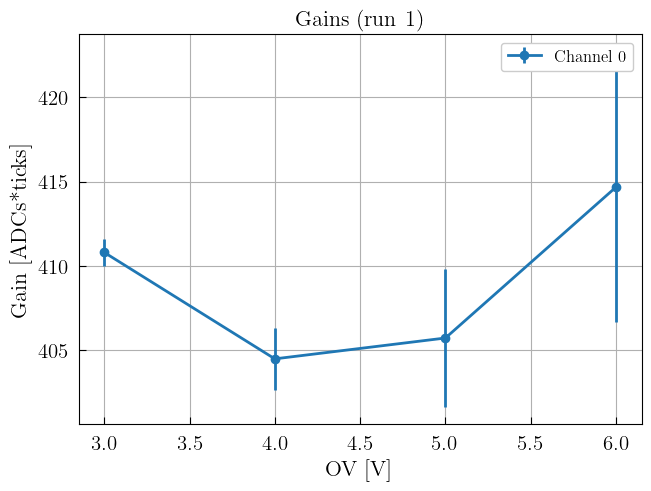

In [10]:
channels    = [0,6];      run   = 1
folder_path = "TUTORIAL"; debug = False
my_ov       = [[3,4,5,6],[3]]

gains, Dgain = get_gains(run,channels,folder_path=folder_path,debug=debug)
print("STORED GAINS -> ",gains)
print("STORED DGAIN -> ",Dgain)

for c,ch in enumerate(channels):
    filter_gains = np.array(gains[ch])[np.array(gains[ch])!=-99]
    filter_Dgain = np.array(Dgain[ch])[np.array(Dgain[ch])!=-99]
    if filter_gains.size == 0:
        print("No valid gains for channel %i"%ch)
        continue
    a, b = np.polyfit(my_ov[c], filter_gains, 1)
    print("Channel %i: G = %.2f * OV + %.2f"%(ch,a,b))
    plt.errorbar(my_ov[c], filter_gains, yerr=filter_Dgain, label="Channel "+str(ch), marker = "o")

plt.xlabel("OV [V]"); plt.ylabel("Gain [ADCs*ticks]"); plt.title("Gains (run %i)"%run)
plt.grid(True)
plt.legend()
plt.show()
# plt.savefig("gain_fit_SiPMs.png", dpi = 400)